In [3]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import re
from scipy import stats
import utils
import seaborn as sns
import pingouin as pg
import matplotlib.cm as cm

import statsmodels.stats.power as smp
from statsmodels.stats.anova import AnovaRM


from natsort import index_natsorted

# plt.rcParams['font.family'] = 'Times New Roman'


path_figs = "./Figs/"

seq_length = 7 #Length of sequences

windowSizes = [1, 2, 3, 7]

fingers = ['1', '2', '3', '4', '5'] #mapping of fingers to numbers

iti = 3000   #Inter trial interval
execTime = 10000 # msecs for each trial maximum
precueTime_interval = [600, 1000] # msecs for planning before movement 
hand = 2 #left or right hand

# total_sub_num = 10
sub_nums = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

num_blocks_per_session = 12
num_trials_per_block = 24
num_trails_per_cond = 8

session1_blocks = [_ for _ in range(1, num_blocks_per_session+1)]
session2_blocks = [_ for _ in range(num_blocks_per_session+1, 2*num_blocks_per_session+1)]
session3_blocks = [_ for _ in range(2*num_blocks_per_session+1, 3*num_blocks_per_session+1)]
session4_blocks = [_ for _ in range(3*num_blocks_per_session+1, 4*num_blocks_per_session+2)]


In [4]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.ticker as ticker

def set_figure_style(scale="1col"):
    """
    Set figure styling based on publication constraints.
    
    Parameters:
        scale (str): Scale of the figure, choose from "1col", "1.5col", "2col".
                     - "1col" for 8.5cm
                     - "1.5col" for 11.6cm
                     - "2col" for 17.6cm
    """
    # Define width options in cm
    widths = {"1col": 8.5, "1.5col": 11.6, "2col": 17.6}
    
    if scale not in widths:
        raise ValueError("Invalid scale. Choose from '1col', '1.5col', or '2col'.")
    
    # Convert width from cm to inches (1 cm = 0.393701 inches)
    width_in = widths[scale] * 0.393701
    
    # Set figure size (width, height)
    # Assuming height proportional to width (Golden Ratio)
    golden_ratio = (5**0.5 - 1) / 2
    rcParams["figure.figsize"] = (width_in, width_in * golden_ratio)
    
    # Set font sizes
    # rcParams["font.size"] = 10  # General font size
    rcParams["font.size"] = 20  # General font size
    # rcParams["axes.titlesize"] = 12  # Figure title
    rcParams["axes.titlesize"] = 26  # Figure title
    # rcParams["axes.labelsize"] = 9  # Axis main label
    rcParams["axes.labelsize"] = 22  # Axis main label
    # rcParams["xtick.labelsize"] = 7  # Tick labels
    rcParams["xtick.labelsize"] = 16  # Tick labels
    # rcParams["ytick.labelsize"] = 7
    rcParams["ytick.labelsize"] = 16
    # rcParams["legend.fontsize"] = 8  # Legend entries
    rcParams["legend.fontsize"] = 20  # Legend entries
    rcParams["figure.titleweight"] = "bold"
    
    # Set stroke width
    # rcParams["axes.linewidth"] = 0.75
    rcParams["axes.linewidth"] = 1.5

    rcParams["lines.linewidth"] = 3
    
    # rcParams["xtick.major.width"] = 0.75
    rcParams["xtick.major.width"] = 1.5
    # rcParams["ytick.major.width"] = 0.75
    rcParams["ytick.major.width"] = 1.5

    
    # Subpanel lettering size
    rcParams["text.usetex"] = False  # Set to True if using LaTeX
    rcParams["axes.formatter.use_mathtext"] = True  # Math text for scientific notation

def add_subpanel_label(ax, label, fontsize=20, position=(-0.1, 1.05)):
    """
    Add a subpanel label (e.g., 'a', 'b') to a subplot.
    
    Parameters:
        ax (Axes): Matplotlib Axes object.
        label (str): The label text.
        fontsize (int): Font size for the label.
        position (tuple): Position of the label in axes coordinates.
    """
    ax.text(position[0], position[1], label, transform=ax.transAxes, 
            fontsize=fontsize, fontweight="bold", va="top", ha="left")

###
set_figure_style(scale="1col")




In [5]:
subjs_list = utils.read_dat_files_subjs_list(sub_nums)

for subj in subjs_list: ###Adding IPIs
    utils.add_IPI(subj)

subjs = pd.concat(subjs_list) ###Merging all subjs into one dataframe
subjs.reset_index(inplace=True, drop=True)

subjs_presses = utils.finger_melt(subjs).rename(columns={'isError' : 'isTrialError'})

subjs['condition'] = subjs.apply(utils.seq_condition, axis=1)
subjs_presses['condition'] = subjs_presses.apply(utils.seq_condition, axis=1)

In [6]:
sns.color_palette('colorblind')

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

In [7]:
custom_palette = {
    'M': sns.color_palette('colorblind')[0],
    'S': sns.color_palette('colorblind')[7],
    'M+S': sns.color_palette('colorblind')[1],
    'M+S (changed)': sns.color_palette('colorblind')[3]
}



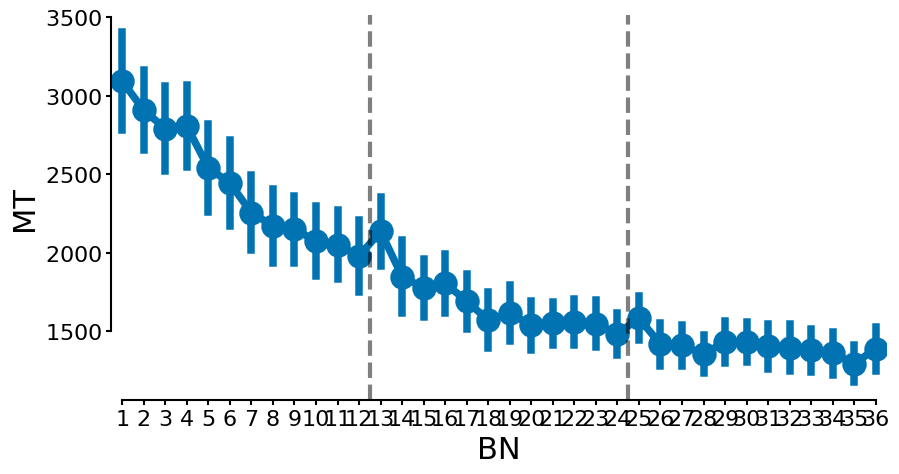

In [24]:
plt.figure(figsize=(10, 5))
subjs_correct = utils.remove_error_trials(subjs)

subjs_grouped = subjs_correct.groupby(['BN', 'SubNum']).agg({
    'MT': 'median'
}).reset_index()

sns.pointplot(data = subjs_grouped, x = 'BN', y = 'MT', errorbar='se', hue = 0,
              palette='colorblind', legend=False)
plt.axvline(x=11.5, color='black', linestyle='--', alpha = 0.5)
plt.axvline(x=23.5, color='black', linestyle='--', alpha = 0.5)
sns.despine(trim=True)

plt.show()

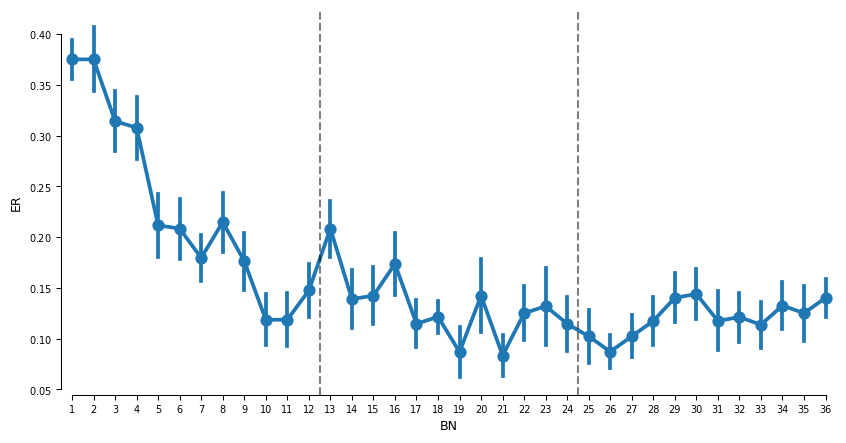

In [50]:
plt.figure(figsize=(10, 5))

subjs_grouped = subjs.groupby(['BN', 'SubNum']).agg({
    'isError': 'sum'
}).reset_index()

subjs_grouped['ER'] = subjs_grouped['isError']/ num_trials_per_block 

sns.pointplot(data = subjs_grouped, x = 'BN', y = 'ER', hue =0, errorbar='se', legend=False)
plt.axvline(x=11.5, color='black', linestyle='--', alpha = 0.5)
plt.axvline(x=23.5, color='black', linestyle='--', alpha = 0.5)
sns.despine(trim=True)

plt.show()

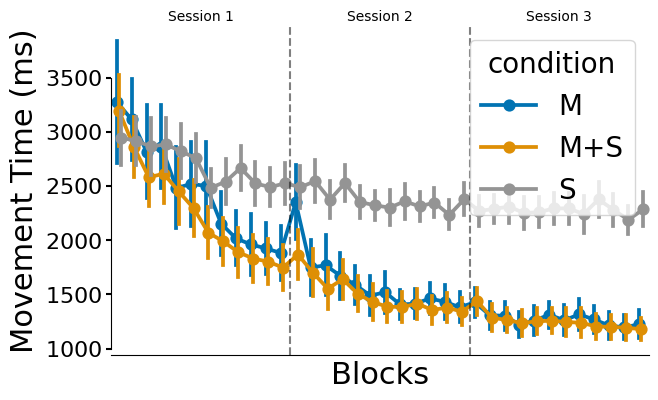

In [15]:
# plt.figure(figsize=(10, 5))
set_figure_style(scale="2col")

subjs_correct = utils.remove_error_trials(subjs)

subjs_grouped = subjs_correct.groupby(['BN', 'SubNum', 'condition']).agg({
    'MT': 'median'
}).reset_index()

sns.pointplot(data = subjs_grouped, x = 'BN', y = 'MT', hue = 'condition', errorbar='se',
              dodge = 0.3, palette=custom_palette)
plt.axvline(x=11.5, color='black', linestyle='--', alpha = 0.5)
plt.axvline(x=23.5, color='black', linestyle='--', alpha = 0.5)


# add text labels for sessions
plt.text(5.5, 4000, 'Session 1', fontsize=10, ha = 'center', va = 'bottom')
plt.text(17.5, 4000, 'Session 2', fontsize=10, ha = 'center', va = 'bottom')
plt.text(29.5, 4000, 'Session 3', fontsize=10, ha = 'center', va = 'bottom')

#removing x axis ticks and labels
plt.gca().xaxis.set_major_locator(ticker.NullLocator())
plt.xlabel('Blocks')
plt.ylabel('Movement Time (ms)')

sns.despine(trim=True)

plt.savefig(path_figs + "MT_sessions.pdf", format = 'pdf', bbox_inches = 'tight')

plt.show()

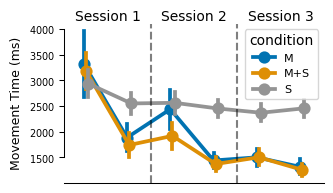

In [196]:
# plt.figure(figsize=(10, 5))
set_figure_style(scale="1col")

included_BNs = [session1_blocks[0], session1_blocks[-1], session2_blocks[0], session2_blocks[-1], session3_blocks[0], session3_blocks[-1]]

subjs_correct = utils.remove_error_trials(subjs)
subjs_correct = subjs_correct[subjs_correct['BN'].isin(included_BNs)]

subjs_grouped = subjs_correct.groupby(['BN', 'SubNum', 'condition']).agg({
    'MT': 'median'
}).reset_index()

sns.pointplot(data = subjs_grouped, x = 'BN', y = 'MT', hue = 'condition', errorbar='se',
              dodge = 0.1, palette=custom_palette)
plt.axvline(x=1.5, color='black', linestyle='--', alpha = 0.5)
plt.axvline(x=3.5, color='black', linestyle='--', alpha = 0.5)

# add text labels for sessions
plt.text(0.5, 4100, 'Session 1', fontsize=10, ha = 'center', va = 'bottom')
plt.text(2.5, 4100, 'Session 2', fontsize=10, ha = 'center', va = 'bottom')
plt.text(4.5, 4100, 'Session 3', fontsize=10, ha = 'center', va = 'bottom')

#removing x axis ticks and labels
plt.gca().xaxis.set_major_locator(ticker.NullLocator())
plt.xlabel('')
plt.ylabel('Movement Time (ms)')


sns.despine(trim=True)



plt.savefig(path_figs + "MT_sessions.pdf", format = 'pdf', bbox_inches = 'tight')

plt.show()

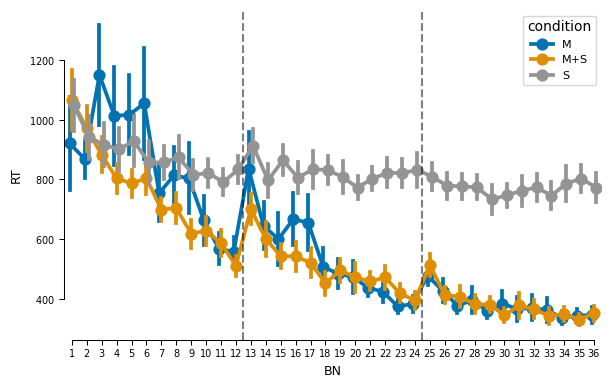

In [96]:
set_figure_style(scale="2col")

subjs_correct = utils.remove_error_trials(subjs)

subjs_grouped = subjs_correct.groupby(['BN', 'SubNum', 'condition']).agg({
    'RT': 'median'
}).reset_index()

sns.pointplot(data = subjs_grouped, x = 'BN', y = 'RT', hue = 'condition', errorbar='se',
              dodge = 0.3, palette=custom_palette)
plt.axvline(x=11.5, color='black', linestyle='--', alpha = 0.5)
plt.axvline(x=23.5, color='black', linestyle='--', alpha = 0.5)
sns.despine(trim=True)

plt.show()

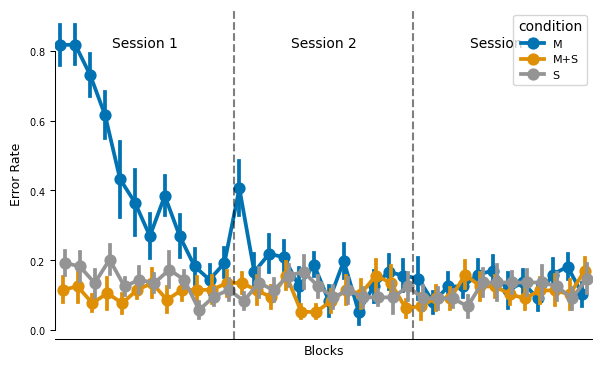

In [7]:
# plt.figure(figsize=(10, 5))
set_figure_style(scale="2col")
subjs_grouped = subjs.groupby(['BN', 'SubNum', 'condition']).agg({
    'isError': 'sum'
}).reset_index()

subjs_grouped['ER'] = subjs_grouped['isError']/ num_trails_per_cond 

sns.pointplot(data = subjs_grouped, x = 'BN', y = 'ER', hue ='condition', 
              errorbar='se', dodge = 0.3, palette= custom_palette)
plt.axvline(x=11.5, color='black', linestyle='--', alpha = 0.5)
plt.axvline(x=23.5, color='black', linestyle='--', alpha = 0.5)

# add text labels for sessions
plt.text(5.5, 0.8, 'Session 1', fontsize=10, ha = 'center', va = 'bottom')
plt.text(17.5, 0.8, 'Session 2', fontsize=10, ha = 'center', va = 'bottom')
plt.text(29.5, 0.8, 'Session 3', fontsize=10, ha = 'center', va = 'bottom')

#removing x axis ticks and labels
plt.gca().xaxis.set_major_locator(ticker.NullLocator())
plt.xlabel('Blocks')
plt.ylabel('Error Rate')

sns.despine(trim=True)

plt.savefig(path_figs + "ER_sessions.pdf", format = 'pdf', bbox_inches = 'tight')

plt.show()

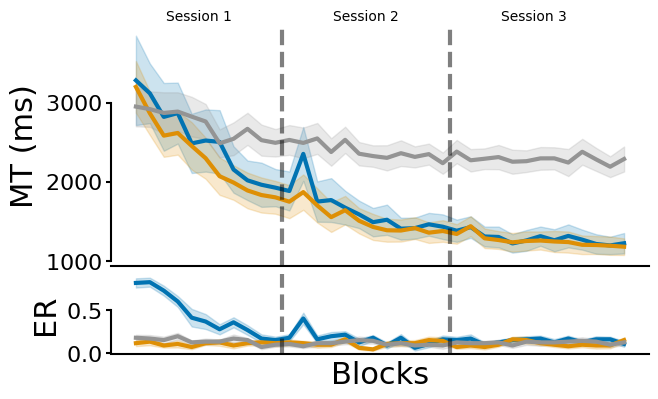

In [55]:
set_figure_style(scale = "2col")

#get height of figure
fig = plt.figure()
fig.canvas.draw()
fig_height = fig.get_figheight()
fig_width = fig.get_figwidth()
fig.clear()
plt.close(fig)

fig = plt.figure(figsize=(fig_width, fig_height * 1))

gs = plt.GridSpec(2, 1, height_ratios=[3, 1], hspace=0.05)



# ---- Movement Time ----
subjs_correct = utils.remove_error_trials(subjs)
subjs_grouped = subjs_correct.groupby(['BN', 'SubNum', 'condition']).agg({
    'MT': 'median'
}).reset_index()

# sns.pointplot(data = subjs_grouped, x = 'BN', y = 'MT', hue = 'condition', errorbar='se',
#               dodge = 0.3, palette=custom_palette, ax=plt.subplot(gs[0]))

sns.lineplot(data = subjs_grouped, x = 'BN', y = 'MT', hue = 'condition', errorbar='se',
             palette=custom_palette, ax=plt.subplot(gs[0]), legend=False)

plt.axvline(x=11.5, color='black', linestyle='--', alpha = 0.5)
plt.axvline(x=23.5, color='black', linestyle='--', alpha = 0.5)

# add text labels for sessions
plt.text(5.5, 4000, 'Session 1', fontsize=10, ha = 'center', va = 'bottom')
plt.text(17.5, 4000, 'Session 2', fontsize=10, ha = 'center', va = 'bottom')
plt.text(29.5, 4000, 'Session 3', fontsize=10, ha = 'center', va = 'bottom')

#removing x axis ticks and labels
plt.gca().xaxis.set_major_locator(ticker.NullLocator())
plt.xlabel('')
# plt.ylabel('Movement Time (ms)')
plt.ylabel('MT (ms)')

# ---- Error Rate ----
subjs_grouped = subjs.groupby(['BN', 'SubNum', 'condition']).agg({
    'isError': 'sum'
}).reset_index()
subjs_grouped['ER'] = subjs_grouped['isError']/ num_trails_per_cond 

# sns.pointplot(data = subjs_grouped, x = 'BN', y = 'ER', hue ='condition', 
#               errorbar='se', dodge = 0.3, palette= custom_palette, ax=plt.subplot(gs[1]))
sns.lineplot(data = subjs_grouped, x = 'BN', y = 'ER', hue ='condition',
             errorbar='se', palette=custom_palette, ax=plt.subplot(gs[1]), legend=False)
plt.axvline(x=11.5, color='black', linestyle='--', alpha = 0.5)
plt.axvline(x=23.5, color='black', linestyle='--', alpha = 0.5)

#removing x axis ticks and labels
plt.gca().xaxis.set_major_locator(ticker.NullLocator())
plt.xlabel('Blocks')
# plt.ylabel('Error Rate')
plt.ylabel('ER')
# plt.legend()

sns.despine(trim=True)

plt.savefig(path_figs + "MT_and_Error_sessions.pdf", format = 'pdf', bbox_inches = 'tight')


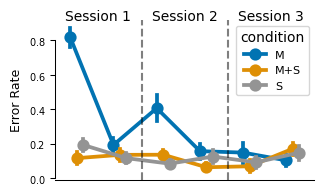

In [143]:
# plt.figure(figsize=(10, 5))
set_figure_style(scale="1col")

included_BNs = [session1_blocks[0], session1_blocks[-1], session2_blocks[0], session2_blocks[-1], session3_blocks[0], session3_blocks[-1]]

subjs_bns = subjs[subjs['BN'].isin(included_BNs)]

subjs_grouped = subjs_bns.groupby(['BN', 'SubNum', 'condition']).agg({
    'isError': 'sum'
}).reset_index()

subjs_grouped['ER'] = subjs_grouped['isError']/ num_trails_per_cond 

sns.pointplot(data = subjs_grouped, x = 'BN', y = 'ER', hue ='condition', 
              errorbar='se', dodge = 0.3, palette= custom_palette)
plt.axvline(x=1.5, color='black', linestyle='--', alpha = 0.5)
plt.axvline(x=3.5, color='black', linestyle='--', alpha = 0.5)

# # add text labels for sessions
plt.text(0.5, 0.9, 'Session 1', fontsize=10, ha = 'center', va = 'bottom')
plt.text(2.5, 0.9, 'Session 2', fontsize=10, ha = 'center', va = 'bottom')
plt.text(4.5, 0.9, 'Session 3', fontsize=10, ha = 'center', va = 'bottom')

#removing x axis ticks and labels
plt.gca().xaxis.set_major_locator(ticker.NullLocator())
plt.xlabel('')
plt.ylabel('Error Rate')


sns.despine(trim=True)

plt.savefig(path_figs + "ER_sessions.pdf", format = 'pdf', bbox_inches = 'tight')

plt.show()

### Horizon Effect:

In [ ]:
set_figure_style(scale="2col")
plt.gcf().get_size_inches()



fig, axs = plt.subplots(1, 3)


array([6.9291376 , 4.28244255])

<Figure size 692.914x428.244 with 0 Axes>

Session 1 ANOVA                        Anova
                     F Value  Num DF  Den DF Pr > F
---------------------------------------------------
windowSize           112.7562 3.0000 39.0000 0.0000
condition             44.5628 1.0000 13.0000 0.0000
windowSize:condition  25.9128 3.0000 39.0000 0.0000

Session 1 paired t-test between window sizes 1 and 2 t-stat: 4.541455127003109, p-value: 0.0005537088205942704
Session 1 paired t-test between window sizes 2 and 3 t-stat: 1.9373552474294022, p-value: 0.07473642892316591
Session 1 paired t-test between window sizes 3 and 7 t-stat: -0.6130611586988642, p-value: 0.5504113965429196
Session 2 ANOVA                        Anova
                     F Value  Num DF  Den DF Pr > F
---------------------------------------------------
windowSize           299.6377 3.0000 39.0000 0.0000
condition            299.0250 1.0000 13.0000 0.0000
windowSize:condition 143.2329 3.0000 39.0000 0.0000

Session 2 paired t-test between window sizes 1 and 2 t-st

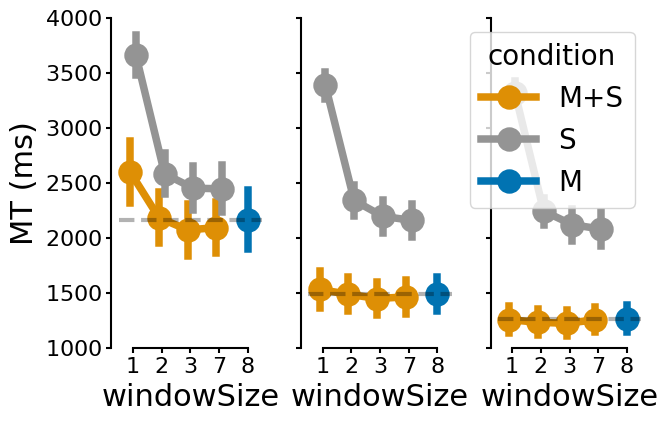

In [24]:
# fig, axs = plt.subplots(1, 3, figsize=(10, 5))
# set_figure_style(scale="1.5col")
set_figure_style(scale="2col")


fig, axs = plt.subplots(1, 3)
for idx, session in enumerate([session1_blocks, session2_blocks, session3_blocks]):
    subjs_sess = subjs[subjs['BN'].isin(session)].copy()
    subjs_correct = utils.remove_error_trials(subjs_sess)
    M_data = subjs_correct[subjs_correct['condition'] == 'M']

    #droping M_data from subjs_correct
    subjs_correct = subjs_correct[subjs_correct['condition'] != 'M']
    
    #create cartesian product to replicate data for each window size
    M_data = M_data.assign(key=1).merge(pd.DataFrame({'windowSize': windowSizes, 'key': 1}), on='key').drop('key', axis=1)
    M_data = M_data.rename(columns={'windowSize_y': 'windowSize'})


    subjs_grouped = subjs_correct.groupby(['SubNum', 'condition', 'windowSize']).agg({
        'MT': 'median'
    }).reset_index()

    M_data_grouped = M_data.groupby(['SubNum', 'condition', 'windowSize']).agg({
        'MT': 'median'
    }).reset_index()


    #for line plot change windowsizes range to 0 to 3
    # M_data_grouped['windowSize'] = M_data_grouped['windowSize'].replace([1, 2, 3, 7], np.array([0, 1, 2, 3]) - 0.1)

    # select only one window size so plot as one point
    M_data_grouped = M_data_grouped[M_data_grouped['windowSize'] == 1]
    M_data_grouped['windowSize'] = 8

    # sns.pointplot(data = M_data_grouped, x = 'windowSize', y = 'MT', hue = 'condition', errorbar='se',
    #             palette=custom_palette, ax = axs[idx])
    
    sns.pointplot(data = subjs_grouped, x = 'windowSize', y = 'MT', hue = 'condition', errorbar='se',
                dodge = 0.2, palette=custom_palette, ax = axs[idx])
    # sns.lineplot(data = M_data_grouped, x = 'windowSize', y = 'MT', hue = 'condition',
    #             palette=custom_palette, ax = axs[idx], legend=False, errorbar='se',
    #             )
    sns.pointplot(data = M_data_grouped, x = 'windowSize', y = 'MT', hue = 'condition', errorbar='se',
                palette=custom_palette, ax = axs[idx])

    axs[idx].hlines(M_data_grouped['MT'].mean(), -0.5, 4.5, color='black', linestyle='--', alpha = 0.3)

    if idx >0:
        axs[idx].set_ylabel('')
        #remove y axis tick labels
        axs[idx].set_yticklabels([])

    if idx <2 :
        #remove legend
        axs[idx].get_legend().remove()

    if idx == 0:
        # axs[idx].set_ylabel('Movement Time (ms)')
        axs[idx].set_ylabel('MT (ms)')


    axs[idx].set_ylim(1000, 4000)
    # axs[idx].set_title(f'Session {idx+1}')

    print(f"Session {idx+1} ANOVA", 
          AnovaRM(subjs_grouped, 'MT', 'SubNum', within=['windowSize', 'condition']).fit())

    # paired t-test between consequtive window sizes
    condition_to_test = 'M+S'
    subjs_grouped = subjs_grouped[subjs_grouped['condition'] == condition_to_test]
    for i in range(len(windowSizes)-1):
        t_stat, p_val = stats.ttest_rel(subjs_grouped[subjs_grouped['windowSize'] == windowSizes[i]]['MT'],
                                subjs_grouped[subjs_grouped['windowSize'] == windowSizes[i+1]]['MT'])
        print(f"Session {idx+1} paired t-test between window sizes {windowSizes[i]} and {windowSizes[i+1]}",
                f"t-stat: {t_stat}, p-value: {p_val}")
        
    # t_stat, p_val = stats.ttest_rel(subjs_grouped[subjs_grouped['windowSize'] == 1]['MT'],
    #                     subjs_grouped[subjs_grouped['windowSize']> 1]['MT'])
    
        

        




sns.despine(trim=True)

# plt.savefig(path_figs + "MT_windowSize.pdf", format = 'pdf', bbox_inches = 'tight')

plt.show()

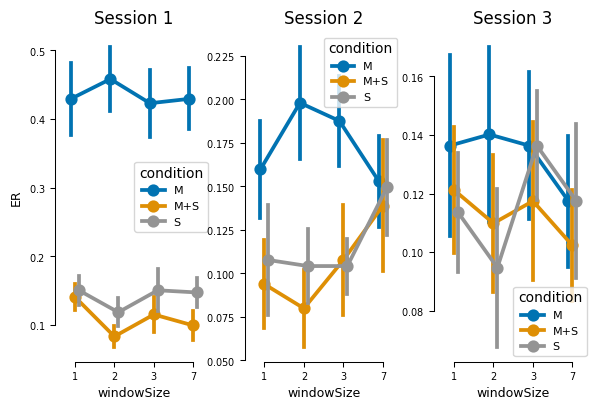

In [183]:
# fig, axs = plt.subplots(1, 3, figsize=(10, 5))
set_figure_style(scale="2col")
fig, axs = plt.subplots(1, 3)
for idx, session in enumerate([session1_blocks, session2_blocks, session3_blocks]):
    subjs_sess = subjs[subjs['BN'].isin(session)].copy()
    subjs_sess['#trial'] = 1

    subjs_grouped = subjs_sess.groupby(['SubNum', 'condition', 'windowSize']).agg({
        'isError': 'sum',
        '#trial': 'count'
    }).reset_index()

    subjs_grouped['ER'] = subjs_grouped['isError']/ subjs_grouped['#trial']

    sns.pointplot(data = subjs_grouped, x = 'windowSize', y = 'ER', hue = 'condition', errorbar='se',
                dodge = 0.2, palette=custom_palette, ax = axs[idx])
    if idx >0:
        axs[idx].set_ylabel('')

    # axs[idx].set_ylim(1000, 4000)
    axs[idx].set_title(f'Session {idx+1}')
sns.despine(trim=True)

plt.savefig(path_figs + "MT_windowSize.pdf", format = 'pdf', bbox_inches = 'tight')

plt.show()

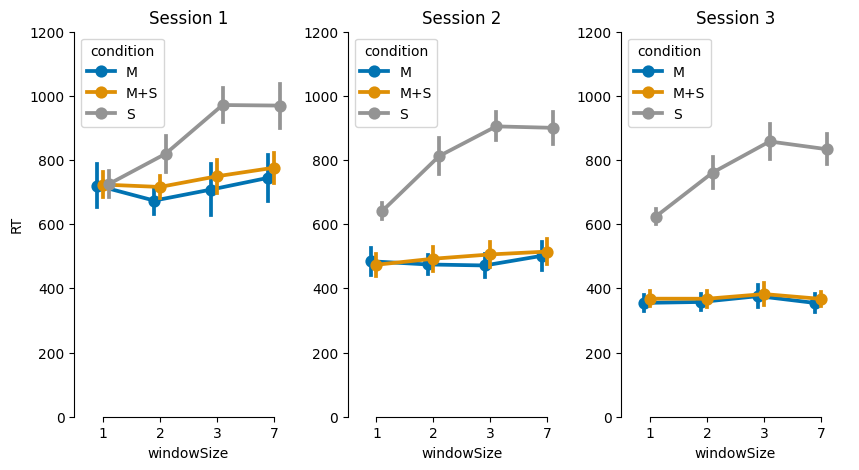

In [27]:
fig, axs = plt.subplots(1, 3, figsize=(10, 5))
for idx, session in enumerate([session1_blocks, session2_blocks, session3_blocks]):
    subjs_sess = subjs[subjs['BN'].isin(session)]
    subjs_correct = utils.remove_error_trials(subjs_sess)

    subjs_grouped = subjs_correct.groupby(['SubNum', 'condition', 'windowSize']).agg({
        'RT': 'median'
    }).reset_index()

    sns.pointplot(data = subjs_grouped, x = 'windowSize', y = 'RT', hue = 'condition', errorbar='se',
                dodge = 0.2, palette=custom_palette, ax = axs[idx])
    if idx >0:
        axs[idx].set_ylabel('')

    axs[idx].set_ylim(0, 1200)
    axs[idx].set_title(f'Session {idx+1}')
sns.despine(trim=True)

plt.show()

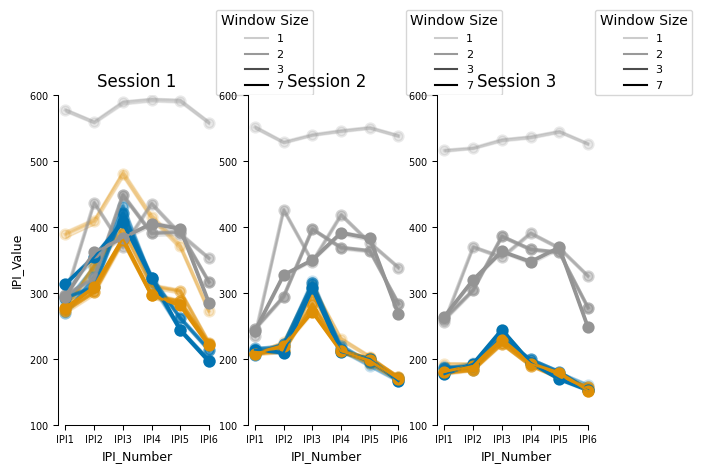

In [93]:
# fig, axs = plt.subplots(3, 1, figsize=(8, 25))
set_figure_style(scale="2col")
fig, axs = plt.subplots(1, 3, figsize=(rcParams["figure.figsize"][0], rcParams["figure.figsize"][1]))
line_styles = ['solid', 'dashdot', 'dashed', 'dotted']
alphas = [0.2, 0.4, 0.7, 1]
for idx, session in enumerate([session1_blocks, session2_blocks, session3_blocks]):
    subjs_sess = subjs_presses[subjs_presses['BN'].isin(session)]
    subjs_correct = utils.remove_error_trials_presses(subjs_sess)

    subjs_grouped = subjs_correct.groupby(['SubNum', 'condition', 'windowSize', 'IPI_Number']).agg({
        'IPI_Value': 'median'
    }).reset_index()

    for window_idx, window in enumerate(windowSizes):
        subjs_grouped_window = subjs_grouped[subjs_grouped['windowSize'] == window]
        # sns.pointplot(data = subjs_grouped_window, x = 'IPI_Number', y = 'IPI_Value', hue = 'condition', errorbar='se',
        #             dodge = 0.2, palette=custom_palette, ax = axs[idx], linestyles=line_styles[window_idx], legend=False)
        sns.pointplot(data = subjs_grouped_window, x = 'IPI_Number', y = 'IPI_Value', hue = 'condition', errorbar=None,
                    palette=custom_palette, ax = axs[idx], alpha = alphas[window_idx], legend=False)
        sns.lineplot(data = subjs_grouped_window, x = 'IPI_Number', y = 'IPI_Value', hue = 'condition', errorbar = ('se', 1/10),
                    palette=custom_palette, ax = axs[idx], alpha = alphas[window_idx])
        
        
    #create custom legend for the line styles
    # custom_lines = [plt.Line2D([0], [0], color='black', linestyle=line_styles[0]),
    #                 plt.Line2D([0], [0], color='black', linestyle=line_styles[1]),
    #                 plt.Line2D([0], [0], color='black', linestyle=line_styles[2]),
    #                 plt.Line2D([0], [0], color='black', linestyle=line_styles[3])]
    custom_lines = [plt.Line2D([0], [0], color='black', alpha = alphas[0]),
                    plt.Line2D([0], [0], color='black', alpha = alphas[1]),
                    plt.Line2D([0], [0], color='black', alpha = alphas[2]),
                    plt.Line2D([0], [0], color='black', alpha = alphas[3])]
    axs[idx].legend(custom_lines, windowSizes, title='Window Size', loc = (1, 1))
    
        

    

    if idx >0:
        axs[idx].set_ylabel('')

    axs[idx].set_ylim(100, 600)
    axs[idx].set_title(f'Session {idx+1}')
sns.despine(trim=True)

plt.savefig(path_figs + "IPI_windowSize.pdf", format = 'pdf', bbox_inches = 'tight')

# plt.show()